In [1]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [2]:
# read data
loan_table = pd.read_csv('/Users/kexinluo/Desktop/DS_take_home/12.loan_grant_data/loan_table.csv', parse_dates = ['date'])
loan_table.head()

,loan_id,loan_purpose,date,loan_granted,loan_repaid
0,19454,investment,2012-03-15,0,NaN
1,496811,investment,2012-01-17,0,NaN
2,929493,other,2012-02-09,0,NaN
3,580653,other,2012-06-27,1,1.0
4,172419,business,2012-05-21,1,0.0


In [3]:
# read data
borrower_table = pd.read_csv('/Users/kexinluo/Desktop/DS_take_home/12.loan_grant_data/borrower_table.csv')
borrower_table.head()

,loan_id,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
0,289774,1,NaN,NaN,8000,0.49,3285,1073,0,0,47,3
1,482590,0,1.0,0.0,4500,1.03,636,5299,1,13500,33,1
2,135565,1,NaN,NaN,6900,0.82,2085,3422,1,24500,38,8
3,207797,0,1.0,0.0,1200,0.82,358,3388,0,0,24,1
4,828078,0,0.0,0.0,6900,0.80,2138,4282,1,18100,36,1


In [4]:
print(loan_table.info())
print('-------------------------')
print(loan_table.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101100 entries, 0 to 101099
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   loan_id       101100 non-null  int64         
 1   loan_purpose  101100 non-null  object        
 2   date          101100 non-null  datetime64[ns]
 3   loan_granted  101100 non-null  int64         
 4   loan_repaid   47654 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 3.9+ MB
None
-------------------------
             loan_id   loan_granted   loan_repaid
count  101100.000000  101100.000000  47654.000000
mean   499666.826726       0.471355      0.644353
std    288662.006929       0.499181      0.478714
min        30.000000       0.000000      0.000000
25%    250333.750000       0.000000      0.000000
50%    499885.000000       0.000000      1.000000
75%    749706.250000       1.000000      1.000000
max    999987.000000 

In [5]:
print(borrower_table.info())
print('-------------------------')
print(borrower_table.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101100 entries, 0 to 101099
Data columns (total 12 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   loan_id                                          101100 non-null  int64  
 1   is_first_loan                                    101100 non-null  int64  
 2   fully_repaid_previous_loans                      46153 non-null   float64
 3   currently_repaying_other_loans                   46153 non-null   float64
 4   total_credit_card_limit                          101100 non-null  int64  
 5   avg_percentage_credit_card_limit_used_last_year  94128 non-null   float64
 6   saving_amount                                    101100 non-null  int64  
 7   checking_amount                                  101100 non-null  int64  
 8   is_employed                                      101100 non-null  int64  
 9   yearly_salary  

# Data processing

In [6]:
# merge loan and borrower information
data = pd.merge(left=loan_table, right=borrower_table, on='loan_id')
data.head()

,loan_id,loan_purpose,date,loan_granted,loan_repaid,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
0,19454,investment,2012-03-15,0,NaN,1,NaN,NaN,8600,0.79,1491,6285,1,45200,42,7
1,496811,investment,2012-01-17,0,NaN,1,NaN,NaN,5300,0.52,141,5793,0,0,42,5
2,929493,other,2012-02-09,0,NaN,1,NaN,NaN,0,NaN,660,3232,1,26500,60,4
3,580653,other,2012-06-27,1,1.0,0,1.0,0.0,5400,0.52,3345,2764,1,15800,58,4
4,172419,business,2012-05-21,1,0.0,1,NaN,NaN,2900,0.76,1050,3695,1,34800,31,4


Remove the rows where loan not granted as they should not be used in the model

In [7]:
data = data.loc[data['loan_granted'] == 1]
data.shape

(47654, 16)

In [8]:
# parse date information and extract month, week, and dayofweek information
data['month'] = data['date'].apply(lambda x: x.month)
data['week'] = data['date'].apply(lambda x: x.week)
data['dayofweek'] = data['date'].apply(lambda x: x.dayofweek)

# drop useless features
data = data.drop(labels=['loan_id', 'date', 'loan_granted'], axis=1, inplace=False)

Next, set 'NaN' in 'fully_repaid_previous_loans' and 'currently_repaying_other_loans' as -1, which indicates the brower is asking for loan the first time, and discard 'is_first' feature, since its information has already been included in '-1' in 'repay_prev' and 'paying_others'

In [9]:
data.fillna({'fully_repaid_previous_loans':-1,'currently_repaying_other_loans':-1},inplace=True)
data = data.drop(labels=['is_first_loan'], axis=1, inplace=False)
data.head()

,loan_purpose,loan_repaid,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number,month,week,dayofweek
3,other,1.0,1.0,0.0,5400,0.52,3345,2764,1,15800,58,4,6,26,2
4,business,0.0,-1.0,-1.0,2900,0.76,1050,3695,1,34800,31,4,5,21,0
6,business,1.0,1.0,0.0,7800,0.30,4206,4368,1,51100,51,2,3,11,2
7,emergency_funds,0.0,0.0,1.0,4300,1.02,886,1597,1,15000,59,2,8,35,4
8,investment,1.0,1.0,0.0,3900,0.65,1837,3795,1,12000,24,1,5,21,4


Check employment and salary

In [10]:
data.loc[data.is_employed==0,'yearly_salary'].value_counts()

0    4297
Name: yearly_salary, dtype: int64

In [11]:
data.loc[data.yearly_salary==0,'is_employed'].value_counts()

0    4297
1       9
Name: is_employed, dtype: int64

All unemployed has 0 salary, and most borrower with salary = 0 are unemployed. 

We could drop 'is_employed' as it is quite redundant given 'yearly_salary'.

In [12]:
data = data.drop(labels=['is_employed'], axis=1, inplace=False)

Impute avg_percentage_credit_card_limit_used_last_year

In [13]:
# fill missing values with median
median = data['avg_percentage_credit_card_limit_used_last_year'].median()
data = data.fillna({'avg_percentage_credit_card_limit_used_last_year': median})

# Visualization

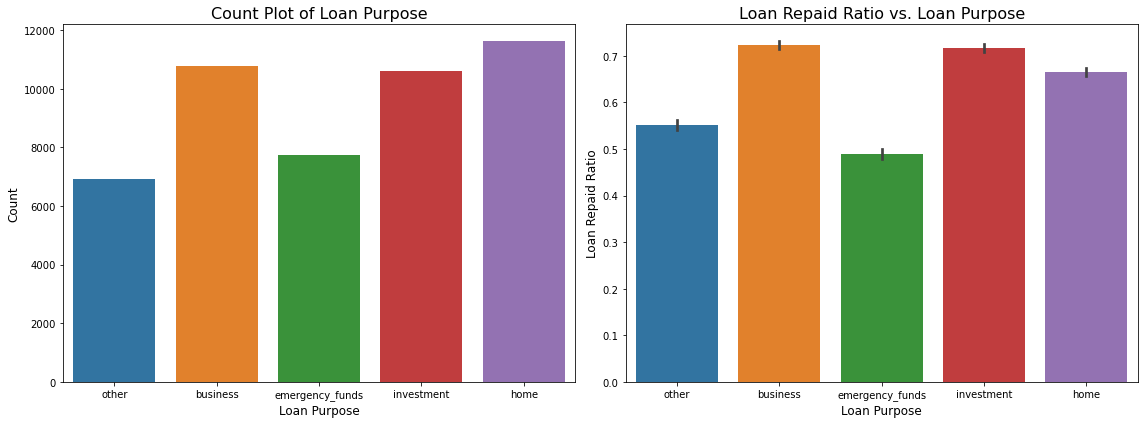

In [14]:
# visualization of 'loan_purpose'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='loan_purpose', data=data, ax=ax[0])
ax[0].set_xlabel('Loan Purpose', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Loan Purpose', fontsize=16)

sns.barplot(x='loan_purpose', y='loan_repaid', data=data, ax=ax[1])
ax[1].set_xlabel('Loan Purpose', fontsize=12)
ax[1].set_ylabel('Loan Repaid Ratio', fontsize=12)
ax[1].set_title('Loan Repaid Ratio vs. Loan Purpose', fontsize=16)
plt.tight_layout()
plt.show()

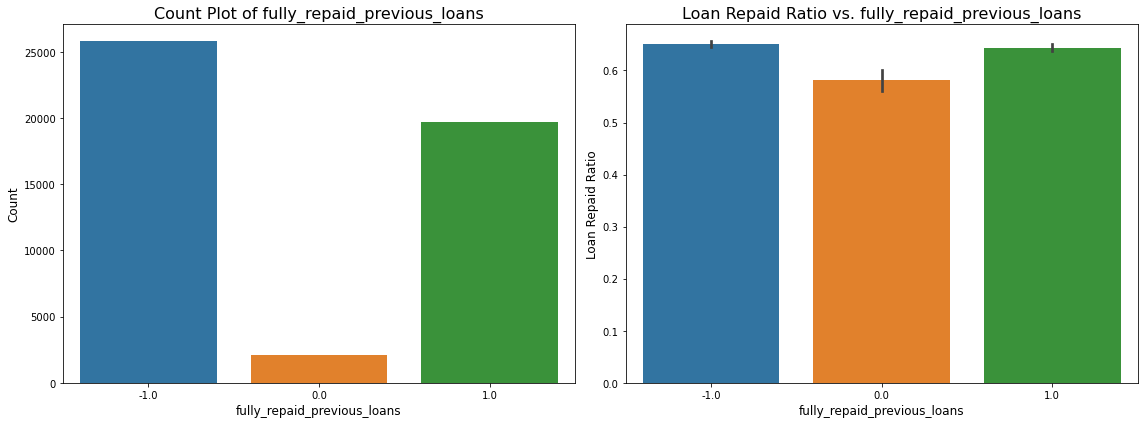

In [15]:
# visualization of 'fully_repaid_previous_loans'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='fully_repaid_previous_loans', data=data, ax=ax[0])
ax[0].set_xlabel('fully_repaid_previous_loans', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of fully_repaid_previous_loans', fontsize=16)

sns.barplot(x='fully_repaid_previous_loans', y='loan_repaid', data=data, ax=ax[1])
ax[1].set_xlabel('fully_repaid_previous_loans', fontsize=12)
ax[1].set_ylabel('Loan Repaid Ratio', fontsize=12)
ax[1].set_title('Loan Repaid Ratio vs. fully_repaid_previous_loans', fontsize=16)
plt.tight_layout()
plt.show()

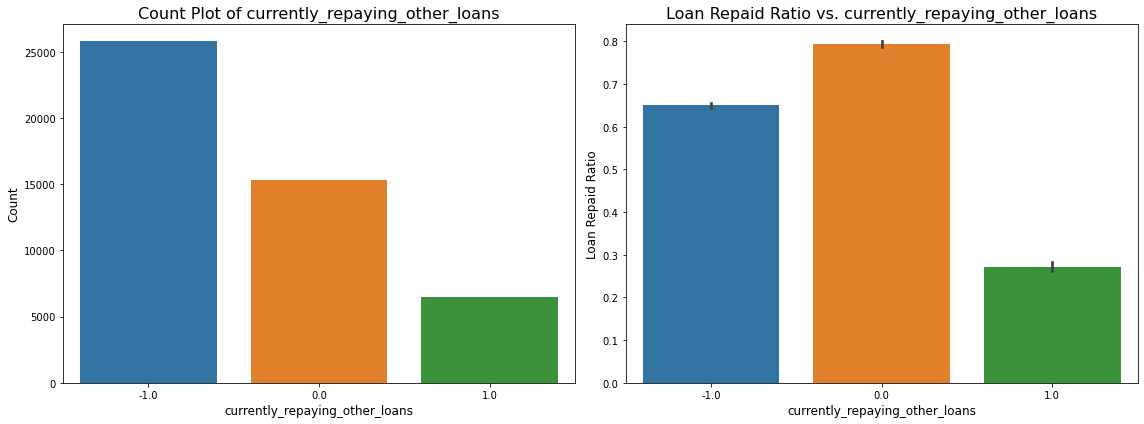

In [16]:
# visualization of 'currently_repaying_other_loans'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='currently_repaying_other_loans', data=data, ax=ax[0])
ax[0].set_xlabel('currently_repaying_other_loans', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of currently_repaying_other_loans', fontsize=16)

sns.barplot(x='currently_repaying_other_loans', y='loan_repaid', data=data, ax=ax[1])
ax[1].set_xlabel('currently_repaying_other_loans', fontsize=12)
ax[1].set_ylabel('Loan Repaid Ratio', fontsize=12)
ax[1].set_title('Loan Repaid Ratio vs. currently_repaying_other_loans', fontsize=16)
plt.tight_layout()
plt.show()

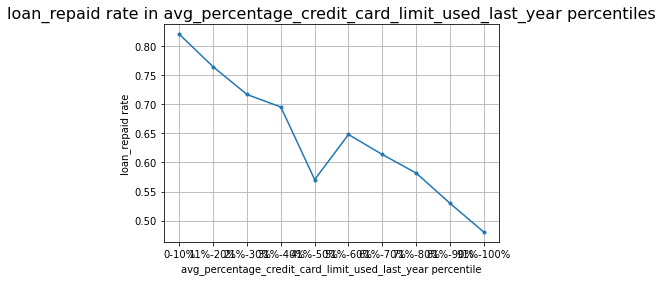

In [17]:
# Visualize avg_percentage_credit_card_limit_used_last_year	
labels=['0-10%', '11%-20%', '21%-30%', '31%-40%','41%-50%','51%-60%','61%-70%','71%-80%','81%-90%', '91%-100%']
data['avg_percentage_credit_card_limit_used_last_year_pt'] = pd.qcut(data['avg_percentage_credit_card_limit_used_last_year'], q=10, labels=labels)
df = data[['avg_percentage_credit_card_limit_used_last_year_pt','loan_repaid']].groupby('avg_percentage_credit_card_limit_used_last_year_pt').mean().reset_index()

# plot with the percentile of salaries as the x axis and the proportion of quiters as the y axis
plt.plot(df['avg_percentage_credit_card_limit_used_last_year_pt'], df['loan_repaid'], '.-')
plt.title('loan_repaid rate in avg_percentage_credit_card_limit_used_last_year percentiles', fontsize=16)
plt.xlabel('avg_percentage_credit_card_limit_used_last_year percentile')
plt.ylabel('loan_repaid rate')
plt.grid(True)
plt.show()

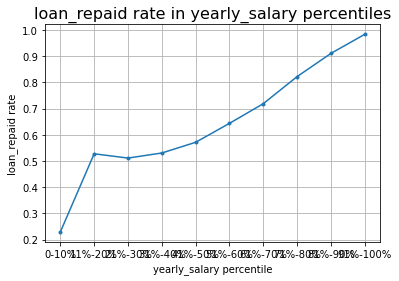

In [18]:
# Visualize yearly_salary
labels=['0-10%', '11%-20%', '21%-30%', '31%-40%','41%-50%','51%-60%','61%-70%','71%-80%','81%-90%', '91%-100%']
data['yearly_salary_pt'] = pd.qcut(data['yearly_salary'], q=10, labels=labels)
df = data[['yearly_salary_pt','loan_repaid']].groupby('yearly_salary_pt').mean().reset_index()

# plot with the percentile of salaries as the x axis and the proportion of quiters as the y axis
plt.plot(df['yearly_salary_pt'], df['loan_repaid'], '.-')
plt.title('loan_repaid rate in yearly_salary percentiles', fontsize=16)
plt.xlabel('yearly_salary percentile')
plt.ylabel('loan_repaid rate')
plt.grid(True)
plt.show()

# Modelling

In [19]:
data.head()

,loan_purpose,loan_repaid,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,yearly_salary,age,dependent_number,month,week,dayofweek,avg_percentage_credit_card_limit_used_last_year_pt,yearly_salary_pt
3,other,1.0,1.0,0.0,5400,0.52,3345,2764,15800,58,4,6,26,2,11%-20%,11%-20%
4,business,0.0,-1.0,-1.0,2900,0.76,1050,3695,34800,31,4,5,21,0,61%-70%,61%-70%
6,business,1.0,1.0,0.0,7800,0.30,4206,4368,51100,51,2,3,11,2,0-10%,91%-100%
7,emergency_funds,0.0,0.0,1.0,4300,1.02,886,1597,15000,59,2,8,35,4,91%-100%,11%-20%
8,investment,1.0,1.0,0.0,3900,0.65,1837,3795,12000,24,1,5,21,4,31%-40%,11%-20%


In [20]:
# define categorical features
categorical_feature = ['loan_purpose', 'fully_repaid_previous_loans', 
                       'currently_repaying_other_loans']
target = 'loan_repaid'

data[categorical_feature] = data[categorical_feature].astype('category')
data[target] = data[target].astype('category')

In [21]:
y = data[target]
X = data.drop(columns=['loan_repaid', 'avg_percentage_credit_card_limit_used_last_year_pt', 'yearly_salary_pt','month','week','dayofweek'])
X.head()

,loan_purpose,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,yearly_salary,age,dependent_number
3,other,1.0,0.0,5400,0.52,3345,2764,15800,58,4
4,business,-1.0,-1.0,2900,0.76,1050,3695,34800,31,4
6,business,1.0,0.0,7800,0.30,4206,4368,51100,51,2
7,emergency_funds,0.0,1.0,4300,1.02,886,1597,15000,59,2
8,investment,1.0,0.0,3900,0.65,1837,3795,12000,24,1


In [22]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47654 entries, 3 to 101098
Data columns (total 10 columns):
 #   Column                                           Non-Null Count  Dtype   
---  ------                                           --------------  -----   
 0   loan_purpose                                     47654 non-null  category
 1   fully_repaid_previous_loans                      47654 non-null  category
 2   currently_repaying_other_loans                   47654 non-null  category
 3   total_credit_card_limit                          47654 non-null  int64   
 4   avg_percentage_credit_card_limit_used_last_year  47654 non-null  float64 
 5   saving_amount                                    47654 non-null  int64   
 6   checking_amount                                  47654 non-null  int64   
 7   yearly_salary                                    47654 non-null  int64   
 8   age                                              47654 non-null  int64   
 9   dependent_number

In [23]:
# split into training and test data set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [24]:
# create LightGBM dataset
d_train = lgb.Dataset(data=X_train, label=y_train, categorical_feature=categorical_feature)

In [ ]:
# Cross validation
params = {'learning_rate': 0.01, 
          'boosting_type': 'gbdt', 
          'objective': 'binary', 
          'metric': ['binary_logloss', 'auc'], 
          'sub_feature':0.5, 
          'num_leaves': 31, 
          'min_data': 50, 
          'max_depth': 30, 
          'is_unbalance': True}

history = lgb.cv(params, train_set=d_train, num_boost_round=1000, nfold=5, 
                 early_stopping_rounds=20, seed=42, verbose_eval=False)

print('Best rounds:\t', len(history['auc-mean']))


In [ ]:
# re-train the model and make predictions
clf = lgb.train(params, train_set=d_train, num_boost_round=767)
pred = clf.predict(X_test)